In [1]:
import torch
import triton
import triton.language as tl
print(torch.cuda.is_available())

True


In [2]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

#### Forward Pass

In [3]:
@triton.jit
def _layer_norm_fwd_fused(
    X, # pointer to the input
    Y, # pointer to the output
    W, # pointer to the weights
    B, # pointer to the biases
    Mean, # pointer to the mean
    Rstd, # pointer to the $ 1/std $
    stride, # magnitude of increase in pointer when moving by 1 row
    N, # number of columns in X
    eps, # epsilon to avoid division by zero
    BLOCK_SIZE: tl.constexpr,
):
    # map the program id to the row of X and Y it should compute
    row = tl.program_id(axis=0)
    Y += row * stride
    X += row * stride

    # compute mean
    mean = 0
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        a = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        _mean += a

    mean = tl.sum(_mean, axis=0) / N

    # compute variance
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        x = tl.where(cols < N, x - mean, 0.)
        _var += x * x
    
    var = tl.sum(_var, axis=0) / N
    rstd = 1 / tl.sqrt(var + eps)
    
    # Write mean / rstd
    tl.store(Mean + row, mean)
    tl.store(Rstd + row, rstd)
    
    # Normalize and apply linear transformation
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        w = tl.load(W + cols, mask=mask)
        b = tl.load(B + cols, mask=mask)
        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        x_hat = (x - mean) * rstd
        y = x_hat * w + b
        # Write output
        tl.store(Y + cols, y, mask=mask)

#### The Backward Pass

In [4]:
@triton.jit
def _layer_norm_bwd_dx_fused(DX,  # pointer to the input gradient
                             DY,  # pointer to the output gradient
                             DW,  # pointer to the partial sum of weights gradient
                             DB,  # pointer to the partial sum of biases gradient
                             X,  # pointer to the input
                             W,  # pointer to the weights
                             Mean,  # pointer to the mean
                             Rstd,  # pointer to the 1/std
                             Lock,  # pointer to the lock
                             stride,  # how much to increase the pointer when moving by 1 row
                             N,  # number of columns in X
                             GROUP_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of X, DX, and DY it should compute.
    row = tl.program_id(0)
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    X += row * stride
    DY += row * stride
    DX += row * stride
    
    # Offset locks and weights/biases gradient pointer for parallel reduction
    lock_id = row % GROUP_SIZE_M
    Lock += lock_id
    Count = Lock + GROUP_SIZE_M
    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols
    
    # Load data to SRAM
    x = tl.load(X + cols, mask=mask, other=0).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0).to(tl.float32)
    w = tl.load(W + cols, mask=mask).to(tl.float32)
    mean = tl.load(Mean + row)
    rstd = tl.load(Rstd + row)
    
    # Compute dx
    xhat = (x - mean) * rstd
    wdy = w * dy
    xhat = tl.where(mask, xhat, 0.)
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(xhat * wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (xhat * c1 + c2)) * rstd
    
    # Write dx
    tl.store(DX + cols, dx, mask=mask)
    
    # Accumulate partial sums for dw/db
    partial_dw = (dy * xhat).to(w.dtype)
    partial_db = (dy).to(w.dtype)
    
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    count = tl.load(Count)
    # First store doesn't accumulate
    if count == 0:
        tl.atomic_xchg(Count, 1)
    else:
        partial_dw += tl.load(DW, mask=mask)
        partial_db += tl.load(DB, mask=mask)
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)

    # need a barrier to ensure all threads finished before
    # releasing the lock
    tl.debug_barrier()

    # Release the lock
    tl.atomic_xchg(Lock, 0)


@triton.jit
def _layer_norm_bwd_dwdb(DW,  # pointer to the partial sum of weights gradient
                         DB,  # pointer to the partial sum of biases gradient
                         FINAL_DW,  # pointer to the weights gradient
                         FINAL_DB,  # pointer to the biases gradient
                         M,  # GROUP_SIZE_M
                         N,  # number of columns
                         BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr):
    # Map the program id to the elements of DW and DB it should compute.
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    
    # Iterate through the rows of DW and DB to sum the partial sums.
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (rows[:, None] < M) & (cols[None, :] < N)
        offs = rows[:, None] * N + cols[None, :]
        dw += tl.load(DW + offs, mask=mask, other=0.)
        db += tl.load(DB + offs, mask=mask, other=0.)
    
    # Write the final sum to the output.
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(FINAL_DW + cols, sum_dw, mask=cols < N)
    tl.store(FINAL_DB + cols, sum_db, mask=cols < N)

#### Benchmarking 

layer-norm-backward:
          N      Triton      Torch
0    1024.0  129.379286  92.412690
1    1536.0  146.868532  85.531324
2    2048.0  153.121496  82.056758
3    2560.0  159.999994  82.139038
4    3072.0  163.476718  81.605479
5    3584.0  165.097886  83.429676
6    4096.0  166.335020  87.226267
7    4608.0  170.403700  83.781816
8    5120.0  171.142062  83.478259
9    5632.0  171.532994  84.638695
10   6144.0  172.665109  83.449917
11   6656.0  172.137927  84.925040
12   7168.0  172.722889  84.412172
13   7680.0  173.559313  84.166186
14   8192.0  174.297876  86.535209
15   8704.0  177.331069  84.147431
16   9216.0  177.515241  83.528704
17   9728.0  177.680366  84.898910
18  10240.0  177.957997  82.789287
19  10752.0  177.841490  83.806905
20  11264.0  178.204348  82.532742
21  11776.0  178.086959  81.400921
22  12288.0  178.086953  80.467122
23  12800.0  178.397217  80.397145
24  13312.0  177.938174  80.150023
25  13824.0  178.086958  79.811403
26  14336.0  177.810857  80.229452

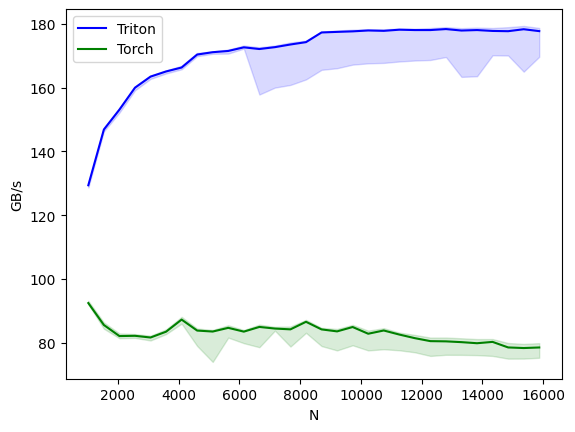

In [5]:
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        
        # allocate output
        y = torch.empty_like(x)
        
        # reshape input data into 2D tensor
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        mean = torch.empty((M, ), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M, ), dtype=torch.float32, device=x.device)
        
        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)
        
        # enqueue kernel
        _layer_norm_fwd_fused[(M, )](  #
            x_arg, y, weight, bias, mean, rstd,  #
            x_arg.stride(0), N, eps,  #
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_ctas=1)
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        x, w, b, m, v = ctx.saved_tensors
        
        # heuristics for amount of parallel reduction stream for DW/DB
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256
        
        # allocate output
        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        dw = torch.empty((N, ), dtype=w.dtype, device=w.device)
        db = torch.empty((N, ), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(dy)
        
        # enqueue kernel using forward pass heuristics
        # also compute partial sums for DW and DB
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        _layer_norm_bwd_dx_fused[(M, )](  #
            dx, dy, _dw, _db, x, w, m, v, locks,  #
            x_arg.stride(0), N,  #
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,  #
            GROUP_SIZE_M=GROUP_SIZE_M,  #
            num_warps=ctx.num_warps)
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE_N']), )
        
        # accumulate partial sums in separate kernel
        _layer_norm_bwd_dwdb[grid](
            _dw, _db, dw, db, min(GROUP_SIZE_M, M), N,  #
            BLOCK_SIZE_M=32,  #
            BLOCK_SIZE_N=128, num_ctas=1)
        return dx, None, dw, db, None


layer_norm = LayerNorm.apply


def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg='provider',
        line_vals=['triton', 'torch'], 
        line_names=['Triton', 'Torch'], 
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm-backward',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'},
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    # backward pass
    if mode == 'backward':
        y = y_fwd()
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles,
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)